# Waveform Selection

## Baseband Signal
To begin with lets generate an example waveform to send. We will assume that the signal is being transmitted continually by the source. The signal should therefore be continious so there is no discontinuity in the output. Initially the waveform shape of choice will be a chirp as a result of its good autocorrelation properties.

In [9]:
import numpy as np
from scipy import signal

# Parameters
fs = 30.72e6
T = 1/fs
L = 6144

# Generate Time Vector
t = np.linspace(0, L*T, L+1)

# Generate Signal - 10kHz to 1MHz Chirp
f0 = 10e3
f1 = 1e6
t1 = L*T
x = signal.chirp(t, f0, t1, f1, method='linear', phi=0)

Now lets plot the time domain signal:

<IPython.core.display.Javascript object>


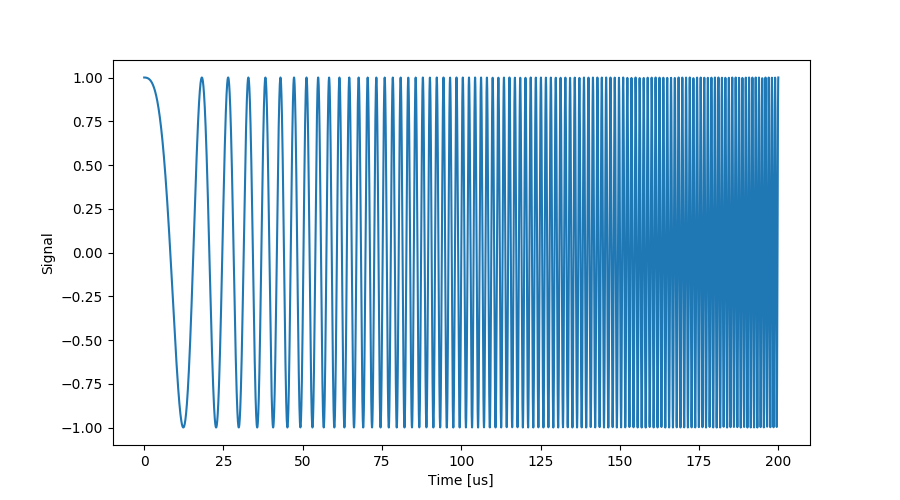

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Generate new figure
fig = plt.figure(figsize=(9, 5))

# Plot x(t) with t in microseconds
plt.plot(t*1e6,x)

# Label Axis
plt.xlabel('Time [us]')
plt.ylabel('Signal')
plt.show()

Lets confirm that L has been chosen correctly to ensure x(t) is continious in time:

In [11]:
x[0] == x[L]

True

## Signal Bandwidth
Next let us look at the frequency spectrum of the time domain signal x(t). Because the signal is real valued the spectrum is symmetric, hence we will just plot the positive half.

<IPython.core.display.Javascript object>


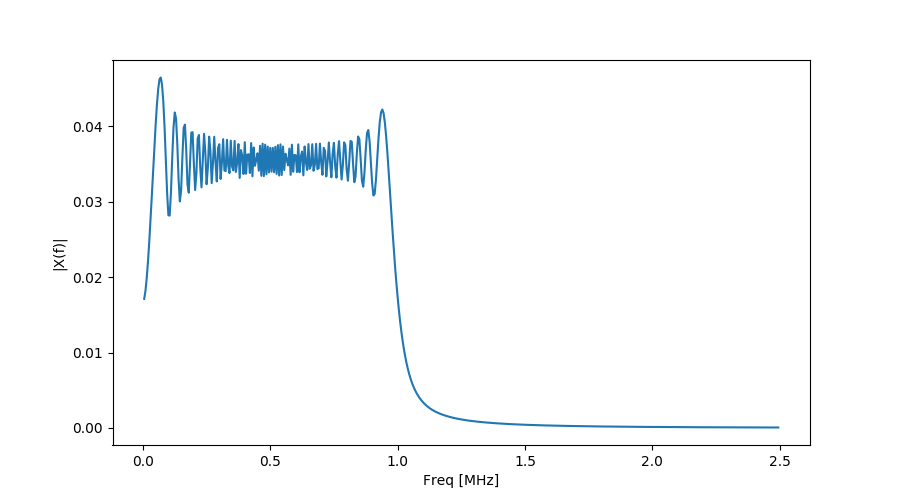

In [12]:
# Compute FFT & Frequency Bins
spectrum = np.fft.fft(x)
freq = np.fft.fftfreq(x.size, T)

# Plot Normalised |X(f)|
fig = plt.figure(figsize=(9, 5))
plt.plot(freq[1:500]/1e6, np.abs(spectrum[1:500])/L)

# Label Axis
plt.xlabel('Freq [MHz]')
plt.ylabel('|X(f)|')
plt.show()

The bandwidth of the signal is equal to the upper instantaneous frequency of the chirp, which in this case is 1MHz.



# Transmission

## Geometry
With the baseband signal selected lets model sending the data. For this we must know the positions of the source and the reference points. Lets choose these in 3D and then plot a the layout. For simplicity we will initially consider just three recievers.

<IPython.core.display.Javascript object>


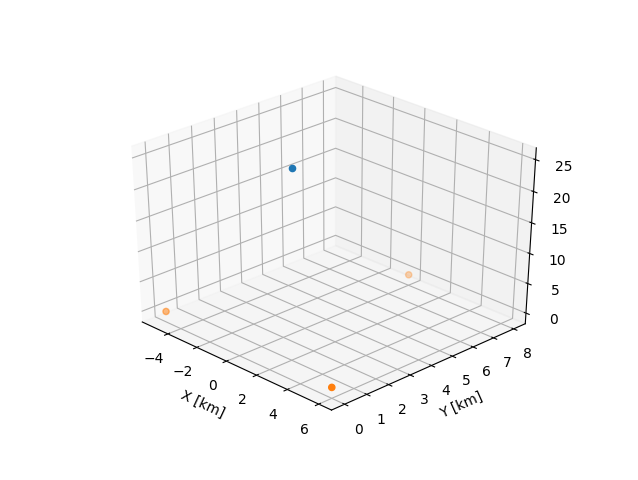

In [57]:
from mpl_toolkits.mplot3d import Axes3D

# TX Co-ordinates (km)
tx = np.array([0, 2.5, 25])

# RX Co-ordinates (km)
rx1 = np.array([-5, 0, 0])
rx2 = np.array([6, 0, 0])
rx3 = np.array([0, 8, 0])

# Plot Geometry
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(*zip(tx))
ax1.scatter(*zip(*(rx1,rx2,rx3)))

# Labels
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.grid(True)
plt.show()

Next lets compute the distance between the transmitter and each of the recievers allowing the time of flight to be determined.

In [34]:
import pandas as pd
from numpy import linalg as LA

# Distances (m)
d1 = LA.norm(tx-rx1)*1e3
d2 = LA.norm(tx-rx2)*1e3
d3 = LA.norm(tx-rx3)*1e3

# Times (s)
t1 = d1/(3e8)
t2 = d2/(3e8)
t3 = d3/(3e8)

# Num. Samples
n1 = t1/T
n2 = t2/T
n3 = t3/T

# Plot Table
tof_data = [[d1,d2,d3], [t1*1e9,t2*1e9,t3*1e9], [n1,n2,n3]]
tof_headings = ['Distance (m)','TOF (ns)', 'Samples']
tof_df = pd.DataFrame(np.transpose(tof_data), ['RX1', 'RX2', 'RX3'], tof_headings)
tof_df.round(2)

,Distance (m),TOF (ns),Samples
RX1,25617.38,85391.26,2623.22
RX2,25831.18,86103.94,2645.11
RX3,25597.85,85326.17,2621.22


## Time Delay

Lets visualise the time delay between the recieved signals. For now we will just round the TOF to be an integer multiple of the sampling period, which is equal to about 32.55 ns. This will give a conservative estimate of the system performance in return for increased simplicity of the model. Because x(t) is continious we can simply wrap the signal around.

<IPython.core.display.Javascript object>


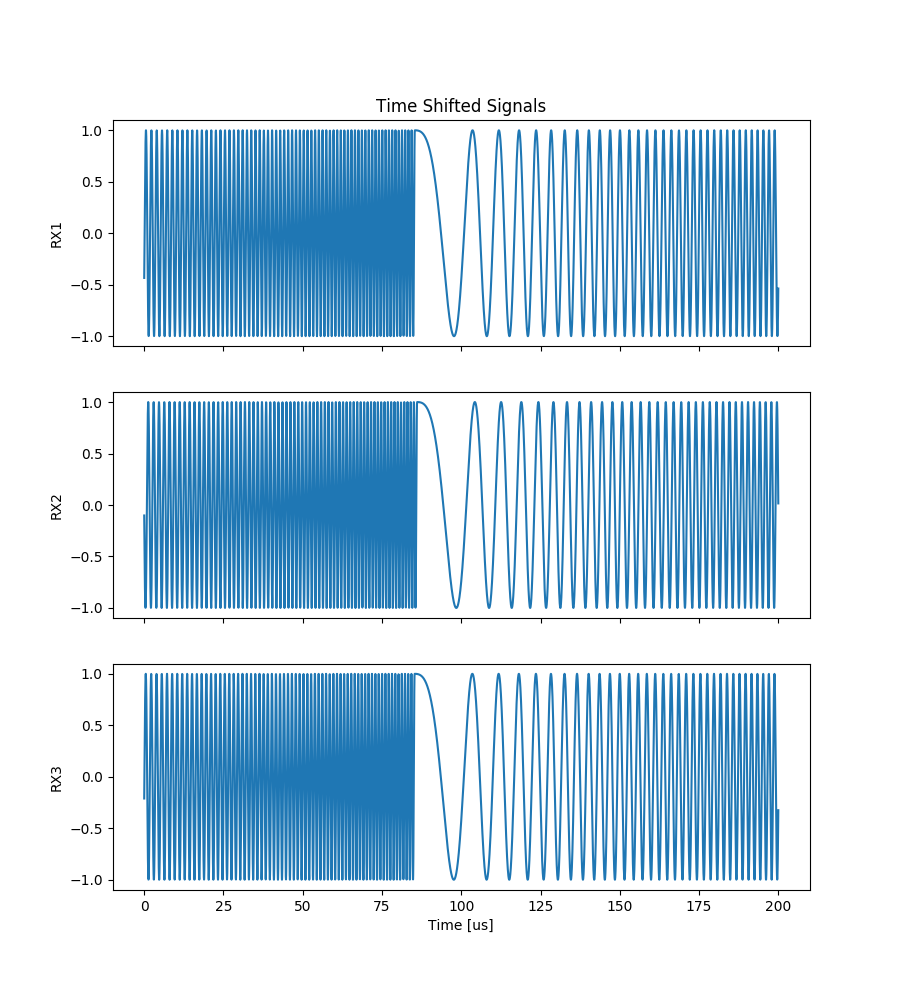

In [37]:
# Generate Recieved Signals
rx1_signal = np.roll(x, int(np.round(n1)))
rx2_signal = np.roll(x, int(np.round(n2)))
rx3_signal = np.roll(x, int(np.round(n3)))


# Plot Signals Sharing x-axis
f, axarr = plt.subplots(3, sharex=True, figsize=(9, 10))
axarr[0].plot(t*1e6, rx1_signal)
axarr[1].plot(t*1e6, rx2_signal)
axarr[2].plot(t*1e6, rx3_signal)

# Labels
axarr[0].set_title('Time Shifted Signals')
axarr[0].set_ylabel('RX1')
axarr[1].set_ylabel('RX2')
axarr[2].set_ylabel('RX3')
axarr[2].set_xlabel('Time [us]')

plt.show()

## Link Budget and Noise Margin

In order to compute the power and SNR of the recieved signal we will use the spreadsheet ./system-model.xlsx. This computes the link budget and noise margin for the system based on the above distances and the specifications of the individual reciever blocks. The output values below correspond to the signal that is at the input to the SDR, having passed through the antenna, filter and low noise amplifier.

In [39]:
# Plot Table
snr_dB = [6.8,6.7,6.8]
lnk_data = [[d1,d2,d3], [-70.8,-70.9,-70.8], snr_dB]
lnk_headings = ['Distance (m)','RX Power (dBm)', 'SNR (dB)']
lnk_df = pd.DataFrame(np.transpose(lnk_data), ['RX1', 'RX2', 'RX3'], lnk_headings)
lnk_df.round(2)

,Distance (m),RX Power (dBm),SNR (dB)
RX1,25617.38,-70.8,6.8
RX2,25831.18,-70.9,6.7
RX3,25597.85,-70.8,6.8



# Recieved Signal

## Noise Model

We will now model the process of recieveing the signal with the SDR. Noise will be added to the recieved signals using the following procedure. Firstly the power of the signal vector $x(t)$ must be calculated.

\begin{equation*}
P_{\text{sig}} = \frac{1}{N}\sum_{i=1}^{N} x_{i}^{2}
\end{equation*}

The noise terms will be generated i.i.d according to $n_i \sim \mathcal{N}(0,\,\sigma_{n}^{2})\ $. The power of the noise signal is therefore:

\begin{equation*}
P_{\text{n}} = \frac{1}{N}\sum_{j=1}^{N} \mathbb{E}(n_{j}^{2}) = \sigma_{n}^{2}
\end{equation*}

Hence to ensure the SNR is equal to that tabulated above, $\sigma_{n}^{2}$ must be chosen according to the below equation.

\begin{equation*}
\sigma_{n}^{2} = P_{\text{sig}} \times 10^{-\text{SNR}/10}
\end{equation*}


In [50]:
# Calculate Power of x(t)
sig_power = np.mean(np.square(x))

# Calculate Required Noise Power
noise_power_1 = sig_power*np.power(10, -snr_dB[0]/10)
noise_power_2 = sig_power*np.power(10, -snr_dB[1]/10)
noise_power_3 = sig_power*np.power(10, -snr_dB[2]/10)

# Generate Noise Samples
noise_1 = np.random.normal(0, noise_power_1, np.size(x))
noise_2 = np.random.normal(0, noise_power_2, np.size(x))
noise_3 = np.random.normal(0, noise_power_3, np.size(x))

# Generate Noisey Signals
rx1_signal_noise = rx1_signal + noise_1
rx2_signal_noise = rx2_signal + noise_3
rx3_signal_noise = rx3_signal + noise_3

## Quantisation

Whilst the SNR of the signals is correct, we must also quantise them in order to fully model the process of recieving with the SDR. Mysterious things happen inside the LMS7002M FPRF IC that make it very hard to tell how the output of the ADC relates to the power of the input signal and the RX gain of the SDR. 

In order to better understand this a 1MHz test signal was fed into the RX path of the SDR at a power of -70dBm. The RX gain of the SDR was set to 55dB. This is suuposedly the combined gain of the LNA/TIA/PGA stages in the RX path. The output of the SDR is shown plotted below.

<IPython.core.display.Javascript object>


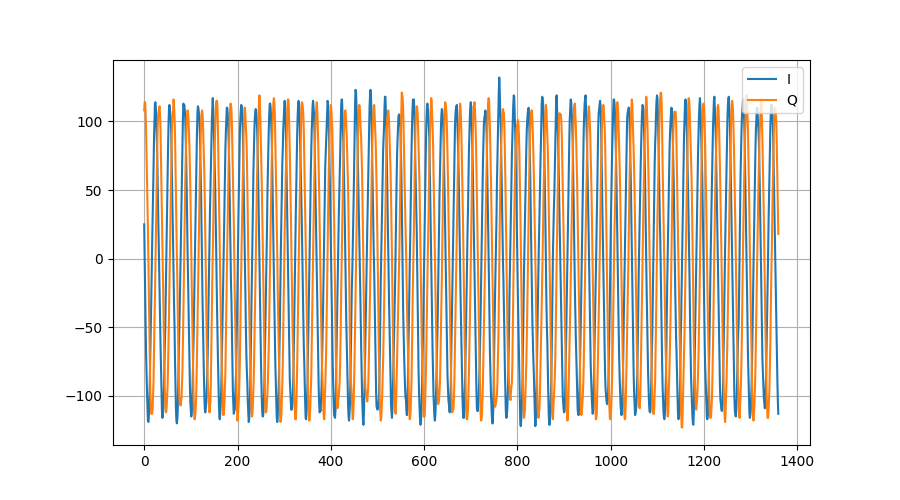

In [51]:
import struct
    
# Open Datafile
file = open('./data/-70_in_55_gain.bin', 'rb')
file.seek(16)

# Create I and Q Arrays
I = np.zeros(1360, dtype=float)
Q = np.zeros(1360, dtype=float)
for n in range(0, 1360):    
    I[n] = struct.unpack('h', file.read(2))[0]
    Q[n] = struct.unpack('h', file.read(2))[0]

# Plot I&Q Channels
fig = plt.figure(figsize=(9, 5))
plt.plot(I[0:1360], label='I')
plt.plot(Q[0:1360], label='Q')
plt.legend(loc='upper right', frameon=True)
plt.grid(True)  
plt.show()

We can see that the amplitude of the output is around 110 units at an input power of -70 dBm with a reciever gain of 55dB. Therefore scaling our noisey signals to $\pm$110 and rounding to the nearest integer should approximate the quantisation process well.

<IPython.core.display.Javascript object>


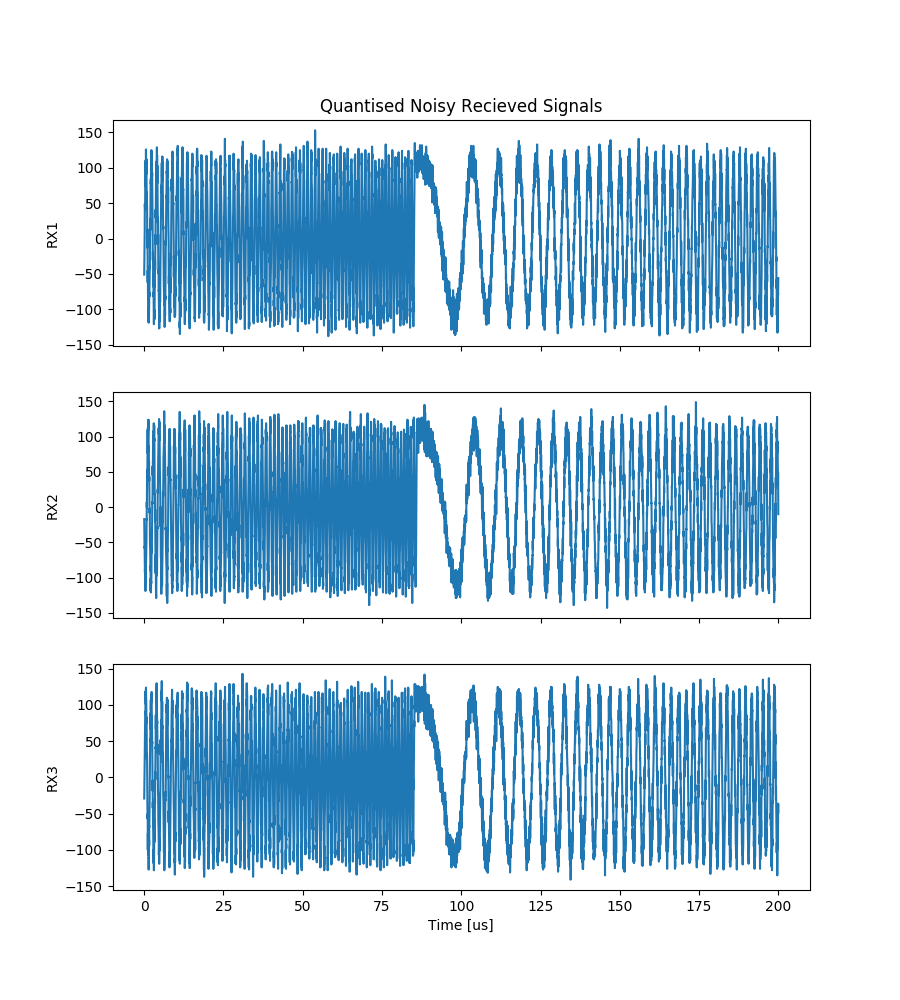

In [58]:
# Quantise the Signal
rx1_signal_out = np.round(rx1_signal_noise*110)
rx2_signal_out = np.round(rx2_signal_noise*110)
rx3_signal_out = np.round(rx3_signal_noise*110)


# Plot Signals Sharing x-axis
f, axarr = plt.subplots(3, sharex=True, figsize=(9, 10))
axarr[0].plot(t*1e6, rx1_signal_out)
axarr[1].plot(t*1e6, rx2_signal_out)
axarr[2].plot(t*1e6, rx3_signal_out)

# Labels
axarr[0].set_title('Quantised Noisy Recieved Signals')
axarr[0].set_ylabel('RX1')
axarr[1].set_ylabel('RX2')
axarr[2].set_ylabel('RX3')
axarr[2].set_xlabel('Time [us]')
plt.show()

# TOF Estimation


Having modelled the output of the SDR we can now attempt to recover the time of flight of the signal. By cross-correlate the transmitted signal $x(t)$ with each of the recieved signals $r_i(t)$ we can estimate the time of flight. Lets do that and compare with the calculated values above. 

<IPython.core.display.Javascript object>


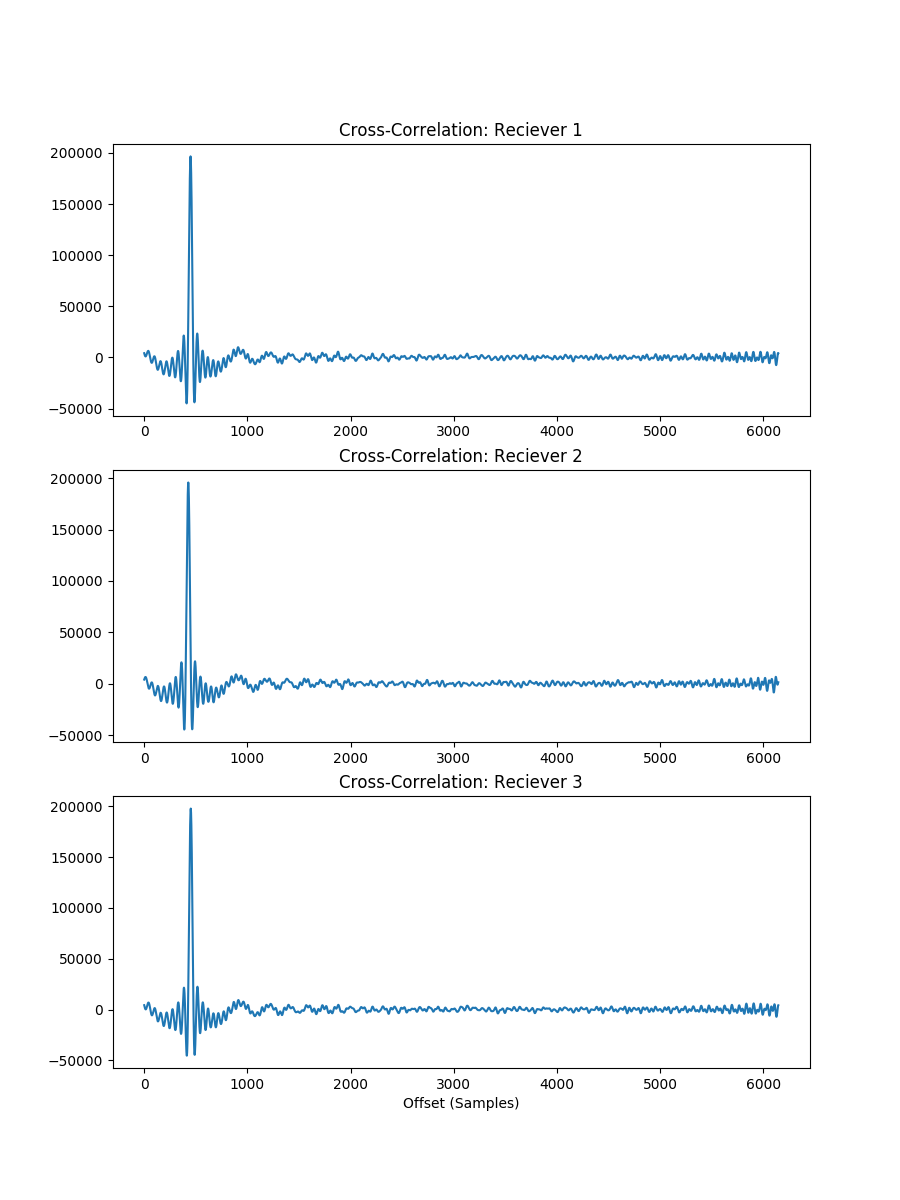

In [59]:
# Compute Cross-Correlation
c1 = signal.correlate(np.asarray(x), np.asarray(rx1_signal_out), 'same')
c2 = signal.correlate(np.asarray(x), np.asarray(rx2_signal_out), 'same')
c3 = signal.correlate(np.asarray(x), np.asarray(rx3_signal_out), 'same')

# Index of Maximum of Cross Correlation
c_tof = [np.argmax(c1),np.argmax(c2),np.argmax(c3)]

# Convert Correlation to Time of Flight
tof = np.zeros(3)
for i in range (0,3):
    if(c_tof[i]<3072):
        tof[i]=3072-c_tof[i]
    else:
        tof[i]=6145-(c_tof[i]-3072)

# Plot Signals Sharing x-axis
f, axarr = plt.subplots(3, figsize=(9, 12))
axarr[0].plot(c1)
axarr[1].plot(c2)
axarr[2].plot(c3)

# Display Graphs
axarr[0].set_title('Cross-Correlation: Reciever 1')
axarr[1].set_title('Cross-Correlation: Reciever 2')
axarr[2].set_title('Cross-Correlation: Reciever 3')
axarr[2].set_xlabel('Offset (Samples)')
plt.show()

In [60]:
# Plot Table
cor_data = [[t1*1e9,t2*1e9,t3*1e9], [n1,n2,n3], tof]
cor_headings = ['TOF (ns)', 'Samples', 'Measured']
cor_df = pd.DataFrame(np.transpose(cor_data), ['RX1', 'RX2', 'RX3'], cor_headings)
cor_df.round(2)

,TOF (ns),Samples,Measured
RX1,85391.26,2623.22,2623.0
RX2,86103.94,2645.11,2645.0
RX3,85326.17,2621.22,2621.0
